# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data 
from torch.utils.data.dataset import random_split


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [28]:
# Define transforms
## YOUR CODE HERE ##

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create training set and define training dataloader
## YOUR CODE HERE ##
trainset = torchvision.datasets.CIFAR10('./data', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10('./data', download=True, train=False, transform=test_transform)

test_size = int(len(testset) * 0.8) # 80% testing data
valid_size = len(testset) - test_size # 20% validation data
test_data, valid_data = torch.utils.data.dataset.random_split(testset, [test_size, valid_size])

testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [29]:
def show5(img_loader):
    batch = next(iter(img_loader))

    labels = batch[1][0:5]
    images = batch[0][0:5]
    fig = plt.figure(figsize=(10,4))

    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        image = images[i].numpy()
        image = image / 2 + 0.5 # unnormalize the images

        plt.imshow(np.rot90(image.T, k=3))
        ax.set_title(classes[labels[i]]) # set img label as plot title

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
torch.Size([64])


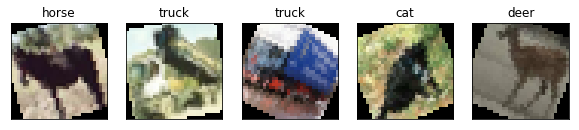

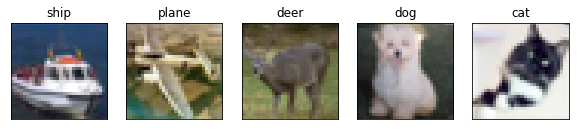

In [30]:
# Explore data
## YOUR CODE HERE ##
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
show5(trainloader)
show5(testloader)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [31]:
## YOUR CODE HERE ##
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 784)
        self.fc2 = nn.Linear(784, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x
    
model = Classifier()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [33]:
## YOUR CODE HERE ##
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(device)

cuda


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [34]:
## YOUR CODE HERE ##


epochs = 20
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))    
                
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(validloader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(validloader)))

Epoch: 1/20..  Training Loss: 1.859..  Validation Loss: 1.719..  Test Accuracy: 0.404
Epoch: 2/20..  Training Loss: 1.708..  Validation Loss: 1.569..  Test Accuracy: 0.435
Epoch: 3/20..  Training Loss: 1.639..  Validation Loss: 1.537..  Test Accuracy: 0.458
Epoch: 4/20..  Training Loss: 1.606..  Validation Loss: 1.545..  Test Accuracy: 0.457
Epoch: 5/20..  Training Loss: 1.572..  Validation Loss: 1.510..  Test Accuracy: 0.483
Epoch: 6/20..  Training Loss: 1.543..  Validation Loss: 1.500..  Test Accuracy: 0.461
Epoch: 7/20..  Training Loss: 1.523..  Validation Loss: 1.488..  Test Accuracy: 0.493
Epoch: 8/20..  Training Loss: 1.504..  Validation Loss: 1.469..  Test Accuracy: 0.486
Epoch: 9/20..  Training Loss: 1.488..  Validation Loss: 1.471..  Test Accuracy: 0.484
Epoch: 10/20..  Training Loss: 1.474..  Validation Loss: 1.449..  Test Accuracy: 0.500
Epoch: 11/20..  Training Loss: 1.466..  Validation Loss: 1.461..  Test Accuracy: 0.479
Epoch: 12/20..  Training Loss: 1.447..  Validation L

Plot the training loss (and validation loss/accuracy, if recorded).

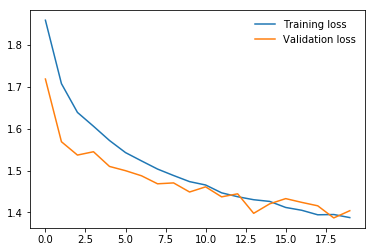

In [35]:
## YOUR CODE HERE ##
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [36]:
## YOUR CODE HERE ##
correct = 0
total = 0

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Turn off gradients to speed up this part
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
Accuracy = 100 * correct / total
print("Overall Correct : {} ".format(correct),
      "Overall Total : {} ".format(total),
      "Overall Accuracy : {:.2f} ".format(Accuracy))

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))



Overall Correct : 3691  Overall Total : 8000  Overall Accuracy : 46.14 
Accuracy for class plane is: 45.3 %
Accuracy for class car   is: 59.9 %
Accuracy for class bird  is: 22.9 %
Accuracy for class cat   is: 30.9 %
Accuracy for class deer  is: 33.6 %
Accuracy for class dog   is: 40.4 %
Accuracy for class frog  is: 62.5 %
Accuracy for class horse is: 51.4 %
Accuracy for class ship  is: 62.8 %
Accuracy for class truck is: 52.8 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [37]:
## YOUR CODE HERE ##
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())
torch.save(model.state_dict(), 'checkpoint.pth')

Our model: 

 Classifier(
  (fc1): Linear(in_features=3072, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias'])


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

### Recommendation

   My model has an accuracy of about 45%. It is less than Detectocorp's algorithm around 25%. However, 70% is not enough for a self-driving car project which we should consider more in safety terms. My recommendation is to try to improve an in-house model to achieve more accuracy. We should learn from research with a benchmark score above 90% such as Maxout Networks; Goodfellow et al., 2013 and Wide Residual Networks; Zagoruyko et al., 2016. 
    




## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).